In [1446]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from pathlib import Path
import plotly.graph_objects as go

C:\Users\gwd007\Documents\Exjobb\data\extracted\group1\N-B_Mid2_Comp.txt_N10, B, 0.11.csv


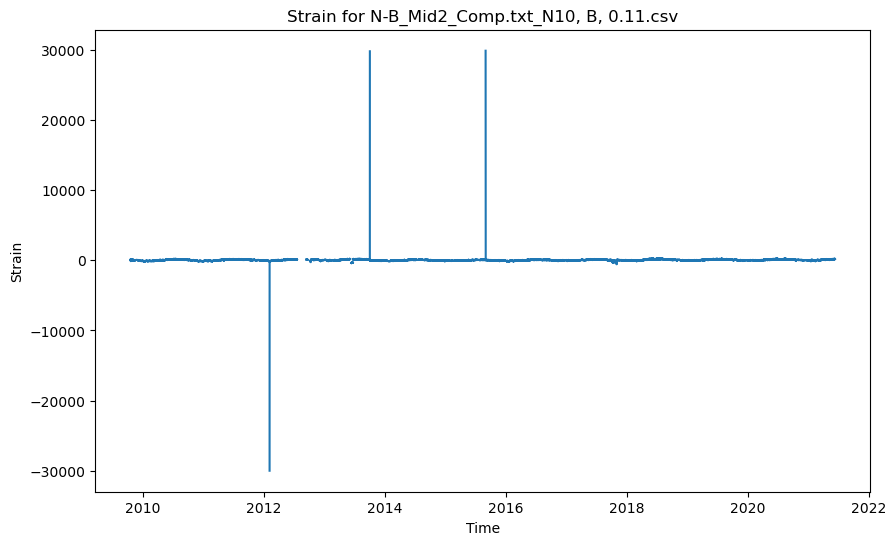

In [1447]:
# Add the root project directory to the Python path
project_root = Path.cwd().parent  # This will get the project root since the notebook is in 'notebooks/'
sys.path.append(str(project_root))

from configs.path_config import EXTRACTED_DATA_DIR

base_dir = EXTRACTED_DATA_DIR
file = 'N-B_Mid2_Comp.txt_N10, B, 0.11.csv'
path = Path(base_dir) / 'group1' / file

print(path)

df = pd.read_csv(path, parse_dates=['Time'])

plt.figure(figsize=(10, 6))
plt.plot(df['Time'], df['Strain'], linestyle='-')
plt.xlabel('Time')
plt.ylabel('Strain')
plt.title(f'Strain for {file}')
plt.show()

In [1448]:
from src.processing import preprocessing

interpolate_threshold = 0
df = preprocessing.clean_zeros_outliers_interpolate(df, interpolate_threshold)

df_orginal = df.copy()
df_mean = df.copy()

130 zeros to replace with NaN
Number of mild outliers (1.5 × IQR): 171
Number of extreme outliers (3 × IQR): 53
Number of outliers replaced with NaN: 171
Number of missing values in df: 2335
Number of missing values in df_filled:2335
Number of missing values filled: 0


In [1449]:
#indentify the regions of missing values
from src.processing import nan_regions #nan_regions.py

threshold = 5 # Choose the threshold(s) for consecutive NaNs
consecutive_nan_regions, nan_regions_sorted = nan_regions.find_nan_regions(df, threshold)

# for threshold in thresholds:

fig = go.Figure()

# Add strain data line
fig.add_trace(go.Scatter(x=df['Time'], y=df['Strain'], mode='lines', name='Strain Data'))

# Shade regions with more than x consecutive NaNs
for start, end in consecutive_nan_regions:
    fig.add_vrect(
        x0=df['Time'].loc[start], x1=df['Time'].loc[end],
        fillcolor='red', opacity=0.3, layer='below', line_width=0
    )

# Print NaN regions information
for column in nan_regions_sorted:
    print(f"Length: {column[4]}, Start Time: {column[2]}, End Time: {column[3]}")

# Figure layout
fig.update_layout(
    title=f'Regions of more than {threshold} consecutive NaNs',
    xaxis_title='Time',
    yaxis_title='Strain',
    legend=dict(x=0, y=1),
)

fig.show()



# for threshold in thresholds:
#     # Plot the data
#     plt.figure(figsize=(20, 6))
#     plt.plot(df['Time'], df['Strain'], linestyle='-', label="Strain Data")

#     # Labels and title
#     plt.xlabel('Time')
#     plt.ylabel('Strain')
#     plt.title(f'Regions of more than {threshold} consecutive NaNs')
#     plt.legend()

#     # Shade regions with more than x consecutive NaNs
#     for start, end in consecutive_nan_regions:
#         plt.axvspan(df['Time'].loc[start], df['Time'].loc[end], color='red', alpha=0.3)
    
#     for column in nan_regions_sorted:
#         print(f"Lenght: {column[4]}, Start Time: {column[2]}, End Time: {column[3]}")
#     plt.show()

Length: 800, Start Time: 2009-06-05 00:00:00, End Time: 2009-10-16 04:00:00
Length: 329, Start Time: 2012-07-18 12:00:00, End Time: 2012-09-11 04:00:00
Length: 105, Start Time: 2013-06-03 08:00:00, End Time: 2013-06-20 16:00:00
Length: 85, Start Time: 2012-09-21 08:00:00, End Time: 2012-10-05 08:00:00
Length: 67, Start Time: 2014-07-11 12:00:00, End Time: 2014-07-22 12:00:00
Length: 41, Start Time: 2014-11-06 12:00:00, End Time: 2014-11-13 04:00:00
Length: 23, Start Time: 2011-11-25 16:00:00, End Time: 2011-11-29 08:00:00
Length: 21, Start Time: 2011-04-04 00:00:00, End Time: 2011-04-07 08:00:00
Length: 20, Start Time: 2013-11-22 00:00:00, End Time: 2013-11-25 04:00:00
Length: 20, Start Time: 2017-09-03 08:00:00, End Time: 2017-09-06 12:00:00
Length: 19, Start Time: 2011-10-28 04:00:00, End Time: 2011-10-31 04:00:00
Length: 18, Start Time: 2014-03-07 08:00:00, End Time: 2014-03-10 04:00:00
Length: 17, Start Time: 2011-07-08 12:00:00, End Time: 2011-07-11 04:00:00
Length: 17, Start Time

In [ ]:
def shift_scale_diff(df, std_multiplier=2.7, n_points_prev=15, n_points_curr=10):
    # Finding the regions with valid values
    valid_indices = df[df['Strain'].notna()].index.tolist()
    consecutive_valid_regions = []
    start_idx = None

    for i in range(len(valid_indices)):
        if start_idx is None:
            start_idx = valid_indices[i]
        if i == len(valid_indices) - 1 or valid_indices[i] + 1 != valid_indices[i + 1]:
            end_idx = valid_indices[i]
            consecutive_valid_regions.append((start_idx, end_idx))
            start_idx = None

    total_shift = 0  # Tracks the accumulated shift to apply to all following regions

    for i in range(1, len(consecutive_valid_regions)):
        prev_start_idx, prev_end_idx = consecutive_valid_regions[i - 1]
        start_idx, end_idx = consecutive_valid_regions[i]

        # Compute mean for the last `n_points_prev` of the previous region (after shifting)
        prev_region_indices = df.loc[prev_start_idx:prev_end_idx].index
        selected_prev_indices = prev_region_indices[-n_points_prev:] if len(prev_region_indices) > n_points_prev else prev_region_indices
        selected_prev_values = df.loc[selected_prev_indices, 'Strain']

        previous_region_mean = selected_prev_values.mean()
        previous_region_std = selected_prev_values.std()

        # Compute mean for the first `n_points_curr` of the current region (before shifting)
        curr_region_indices = df.loc[start_idx:end_idx].index
        selected_curr_indices = curr_region_indices[:n_points_curr] if len(curr_region_indices) > n_points_curr else curr_region_indices
        selected_curr_values = df.loc[selected_curr_indices, 'Strain']

        current_region_mean = selected_curr_values.mean() + total_shift  # Adjust with previous shift

        # Compute bounds
        lower_bound = previous_region_mean - std_multiplier * previous_region_std
        upper_bound = previous_region_mean + std_multiplier * previous_region_std

        # Compute shift amount (align means instead of start-end values)
        shift_value = previous_region_mean - current_region_mean

        # Only shift if the mean of the first `n_points_curr` in the next region is outside the threshold
        if current_region_mean < lower_bound or current_region_mean > upper_bound:
            total_shift += shift_value  # Update the total shift for all subsequent regions

        # Apply the accumulated shift to the current region
        df.loc[start_idx:end_idx, 'Strain'] += total_shift  

    return df


In [1451]:
def shift_scale_diff(df, std_multiplier=2.7, n_points_prev=15, n_points_curr=10):
    # Finding the regions with valid values
    valid_indices = df[df['Strain'].notna()].index.tolist()
    consecutive_valid_regions = []
    start_idx = None

    for i in range(len(valid_indices)):
        if start_idx is None:
            start_idx = valid_indices[i]
        if i == len(valid_indices) - 1 or valid_indices[i] + 1 != valid_indices[i + 1]:
            end_idx = valid_indices[i]
            consecutive_valid_regions.append((start_idx, end_idx))
            start_idx = None

    for i in range(1, len(consecutive_valid_regions)):
        prev_start_idx, prev_end_idx = consecutive_valid_regions[i - 1]
        start_idx, end_idx = consecutive_valid_regions[i]

        # Compute mean for the last `n_points_prev` of the previous region
        prev_region_indices = df.loc[prev_start_idx:prev_end_idx].index
        selected_prev_indices = prev_region_indices[-n_points_prev:] if len(prev_region_indices) > n_points_prev else prev_region_indices
        selected_prev_values = df.loc[selected_prev_indices, 'Strain']

        previous_region_mean = selected_prev_values.mean()
        previous_region_std = selected_prev_values.std()

        # Compute mean for the first `n_points_curr` of the current region
        curr_region_indices = df.loc[start_idx:end_idx].index
        selected_curr_indices = curr_region_indices[:n_points_curr] if len(curr_region_indices) > n_points_curr else curr_region_indices
        selected_curr_values = df.loc[selected_curr_indices, 'Strain']

        current_region_mean = selected_curr_values.mean()

        # Compute bounds
        lower_bound = previous_region_mean - std_multiplier * previous_region_std
        upper_bound = previous_region_mean + std_multiplier * previous_region_std

        # Compute shift amount (align means instead of start-end values)
        shift_value = previous_region_mean - current_region_mean

        # Only shift if the mean of the first `n_points_curr` in the next region is outside the threshold
        if current_region_mean < lower_bound or current_region_mean > upper_bound:
            df.loc[start_idx:end_idx, 'Strain'] += shift_value  # Apply shift only to this region

    return df


In [1452]:
# #Shift values based on difference in strain from end point to start point in the region


# def shift_scale_diff(df):
#     # Finding the regions with valid values
#     valid_indices = df[df['Strain'].notna()].index.tolist()
#     consecutive_valid_regions = []
#     start_idx = None

#     for i in range(len(valid_indices)):
#         if start_idx is None:
#             start_idx = valid_indices[i]
#         if i == len(valid_indices) - 1 or valid_indices[i] + 1 != valid_indices[i + 1]:
#             end_idx = valid_indices[i]
#             if (end_idx - start_idx + 1) >= 1:  # Threshold for region length
#                 consecutive_valid_regions.append((start_idx, end_idx))
#             start_idx = None


#     # Shifting each region based on the previous region's end value
#     previous_end_value = None

#     for i, (start_idx, end_idx) in enumerate(consecutive_valid_regions):
#         if i > 0:  # Skip the first region since there's no previous region to align with
#             current_start_value = df.loc[start_idx, 'Strain']
#             shift_amount = previous_end_value - current_start_value  # Difference between regions
#             df.loc[start_idx:end_idx, 'Strain'] += shift_amount  # Apply shift

#         # Store the last value of this region to align the next one
#         previous_end_value = df.loc[end_idx, 'Strain']

#     return df


In [1453]:
from src.processing import shift_segments       #shift_segments.py

df_diff = shift_scale_diff(df)  
df_mean = shift_segments.shift_scale(df_mean)



fig = go.Figure()

# Add traces for the different data series
fig.add_trace(go.Scatter(x=df_orginal['Time'], y=df_orginal['Strain'], mode='lines', name='Original', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=df_diff['Time'], y=df_diff['Strain'], mode='lines', name='Differenced', line=dict(color='red')))
fig.add_trace(go.Scatter(x=df_mean['Time'], y=df_mean['Strain'], mode='lines', name='Mean', line=dict(color='green')))

# Add labels
fig.update_layout(
    title=f'Strain for {file}',
    xaxis_title='Time',
    yaxis_title='Strain',
    template='plotly_white'
)

# Show the plot
fig.show()
